## D212 Data Mining 2 PA 3
##### Submitted By Edwin Perry
### Table of Contents
<ol>
    <li><a href="#A">Research Question</a></li>
    <li><a href="#B">Technique Justification</a></li>
    <li><a href="#C">Data Preparation</a></li>
    <li><a href="#D">Analysis</a></li>
    <li><a href="#E">Data Summary and Implications</a></li>
    <li><a href="#F">Sources</a></li>
</ol>
<h4 id="A">Research Question</h4>
<h5>Question</h5>
<p>The research question I decided to address in this report is "Can I accurately forecast company revenue using time series analysis in the WGU provided telecommunications dataset?"</p>
<h5>Objectives/Goals</h5>
<p>The goal for this analysis is to accurately forecast the company revenue based on the data included within the csv file. As I do not have distinct datasets provided, showing progression over time, I will instead elect to split my dataset into 2 datasets: a training set consisting of 80% of the dataset, and a test set containing 20% of the dataset. The training set will be used to create the ARIMA time series model, then test set will be used to evaluate the performance. The goal of this is to generate a model that can accurately predict customer revenue</p>
<h4 id="4">Assumption</h4>
<h5>Time Series Assumption</h5>
<p>There are a number of assumptions that must be made for a time series analysis to be a valid analytical practice:
<ul>
<li>The data provided must be stationary. That is, the data cannot be influenced by trends or seasonality, and the mean and variance stay approximately constant over time</li>
<li>The data provided must not suffer from autocorrelation. This means that the entries in earlier rows or times cannot influence the results from future times/rows</li>
</ul>
</p>
<h4 id="C">Data Preparation</h4>
<h5>Time Series Visualization</h5>
<p>Before we begin the analysis, it is important to understand the underlying data. As such, we will start by visualizing how the data changed over time</p>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

df = pd.read_csv('./s8dj4edjf84hd8fcvn3d/teleco_time_series .csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB


<p>Here, we can see that the dataset consists of 2 columns: a day index that stores the count of days that have passed as an integer, and a revenue column that stores the revenue generated in a float.</p>

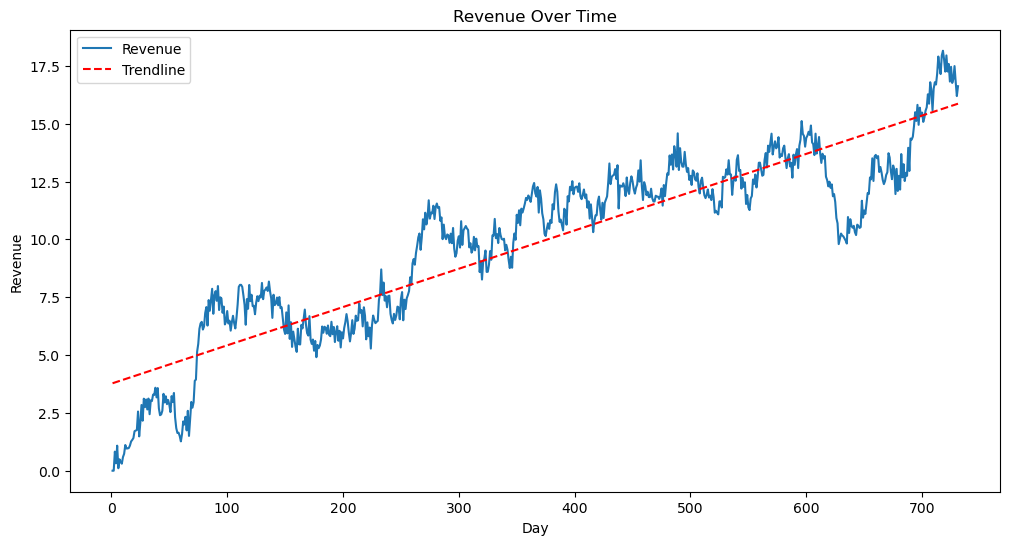

In [5]:
# Plotting the line graph
plt.figure(figsize=(12, 6))
plt.plot(df['Day'], df['Revenue'], label='Revenue')

# Adding a trendline
z = np.polyfit(df['Day'], df['Revenue'], 1)
p = np.poly1d(z)
plt.plot(df['Day'], p(df['Day']), "r--", label='Trendline')

# Adding labels and title
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.title('Revenue Over Time')
plt.legend()
plt.show()
